# Data Set Creation Notebook

This notebook creates the composite data set used in the Geocomputation module. You are welcome to add additional data sets for the purposes of the final assessment in the module if you so wish.

In [2]:
# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
import requests
import pandas as pd
import geopandas as gpd

In [4]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import zipfile
def extract_all(file_path):
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
    
def compress_all(srcdir, name):
    zipf = zipfile.ZipFile(name + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(srcdir, zipf)
    zipf.close()

## London

Useful for filtering down the data sets that we've downloaded from OSOpen.

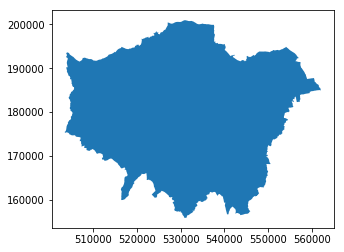

In [5]:
fpath = os.path.join('London','London.shp')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    extract_all(os.path.join('Data','London.zip'))
ldn = gpd.read_file(fpath)
ldn.crs = {'init': u'epsg:27700'}
ldn.plot()

## Lower Super Output Area Data

Downloaded from the [London Data Store](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), with the Output Area shapefile extracted and re-compressed to save space on GitHub. 

In [6]:
# Extract Output Areas
fpath = os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    extract_all(os.path.join('Data','LSOA.zip'))
lsoa = gpd.read_file(fpath)
lsoa.crs = {'init': u'epsg:27700'}

# Stash a copy of original geometry and the centroids
# since we'll need both again
#lsoa['outlines']  = lsoa.geometry
#lsoa['centroids'] = lsoa.geometry.centroid

Unpacking...


In [7]:
# Notice the range of geographies to which we can now join:
# LSOA, MSOA, LA, and Region
# We've also got some very simple, basic measures such as
# population density, usual residents, and average household
# size.
lsoa.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.0919998939 182011.23, 532162...."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.8130000263 181786.891000028, ..."


## OS Open Data Sets

You can download the following data sets from the [OS Open Download Page](https://www.ordnancesurvey.co.uk/opendatadownload/products.html). This step cannot easily be automated, sorry.

* OS Open Map - Local - ESRI SHAPE - TQ
* OS VectorMap District - ESRI Shape - TQ
* OS Open Greenspace - ESRI SHAPE - TQ

For each of these data sets, we have filtered out everything that is _not_ within the GLA boundary. This reduces file size significantly and can be done fairly quickly within QGIS.

### Open Greenspace

In [10]:
buffer_d = 5
fpath = os.path.join('Greenspace','GLA Greenspace.shp')
zpath = os.path.join('Data','Greenspace.zip')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    
    if not (os.path.exists(zpath) and os.path.isfile(zpath)):
        extract_all(os.path.join('Data','opgrsp_essh_tq.zip'))

        grsp = gpd.read_file(os.path.join('OS Open Greenspace (ESRI Shape File) TQ','data','TQ_GreenspaceSite.shp'))
        grsp.crs = {'init': u'epsg:27700'}
        print("Raw file has " + str(grsp.shape[0]) + " rows.")

        grsp = grsp[grsp.function=='Public Park Or Garden']
        grsp = gpd.sjoin(grsp, ldn, how="inner", op='within')

        print("Filtered down to " + str(grsp.shape[0]) + " rows.")

        ensure_dir(fpath)
        grsp.to_file(fpath)

        compress_all('Greenspace',os.path.join('Data','Greenspace'))
    else:
        print("Using processed greenspace data.")
        extract_all(zpath)
        grsp = gpd.read_file(fpath)
        grsp.crs = {'init': u'epsg:27700'}
else:
    print("Loading...")
    grsp = gpd.read_file(fpath)
    grsp.crs = {'init': u'epsg:27700'}

print("Starting buffer (" + str(buffer_d) + "m) and dissolve...")
grspd = grsp.simplify(5).buffer(buffer_d).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(grspd)

print("Saving results to LSOA data frame...")
lsoa['Area that is Designated Greenspace'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Loading...
Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


## A- and M-class Roads

In [11]:
buffer_d = 250
fpath = os.path.join('Roads','Roads.shp')
zpath = os.path.join('Data','Roads.zip')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    
    if not (os.path.exists(zpath) and os.path.isfile(zpath)):
        extract_all(os.path.join('Data','opmplc_essh_tq.zip'))

        rds = gpd.read_file(os.path.join('OS OpenMap Local (ESRI Shape File) TQ','data','TQ_Road.shp'))
        rds.crs = {'init': u'epsg:27700'}
        print("Raw file has " + str(rds.shape[0]) + " rows.")

        rds = rds[rds.CLASSIFICA.isin(['A Road','A Road, Collapsed Dual Carriageway','Motorway','Motorway, Collapsed Dual Carriageway'])]
        rds = gpd.sjoin(rds, ldn, how="inner", op='within')

        print("Filtered down to " + str(rds.shape[0]) + " rows.")

        ensure_dir(os.path.join('Roads','Roads.shp'))
        rds.to_file(os.path.join('Roads','Roads.shp'))

        compress_all('Roads',os.path.join('Data','Roads'))
    else:
        print("Using processed roads data.")
        extract_all(zpath)
        rds = gpd.read_file(fpath)
        rds.crs = {'init': u'epsg:27700'}
        
print("Starting buffer and dissolve...")
impact = rds.simplify(25).buffer(buffer_d).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(impact)

print("Saving results to LSOA data frame...")
lsoa['Area within ' + str(buffer_d) + 'm of M or A Roads'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Unpacking...
Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


## KS402EW - Tenure

In [12]:
tenure = pd.read_excel(os.path.join('Data','KS402EW - Tenure.xlsx'), header=8)
tenure['lsoacd'], tenure['lsoanm'] = tenure['2011 super output area - lower layer'].str.split(' : ').str
tenure.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
tenure.sample(2)
lsoa = pd.merge(lsoa, tenure, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

## KS403EW - Rooms, bedrooms and central heating

In [13]:
rooms = pd.read_excel(os.path.join('Data','KS403EW - Rooms, bedrooms and central heating.xlsx'), header=8)
rooms['lsoacd'], rooms['lsoanm'] = rooms['2011 super output area - lower layer'].str.split(' : ').str
rooms.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
rooms.sample(2)
lsoa = pd.merge(lsoa, rooms, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

## KS201EW - Ethnic group

In [14]:
ethnicity = pd.read_excel(os.path.join('Data','KS201EW - Ethnic group.xlsx'), header=8)
ethnicity['lsoacd'], ethnicity['lsoanm'] = ethnicity['2011 super output area - lower layer'].str.split(' : ').str
ethnicity.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
ethnicity.sample(2)
lsoa = pd.merge(lsoa, ethnicity, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

## AirBnB Listings

We'll just get the smaller data set since we have to summarise anyway.

Data frame shape: (53904, 16)


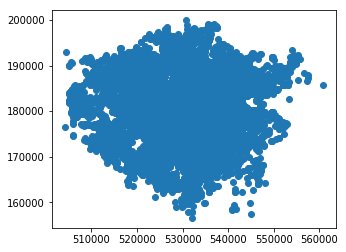

In [16]:
from shapely.geometry import Point

df = pd.read_csv(
    'http://data.insideairbnb.com/united-kingdom/england/london/2017-03-04/visualisations/listings.csv',
    low_memory=False) # The 'low memory' option means pandas doesn't guess data types
print("Data frame shape: " + str(df.shape)) # What is the shape of the data?

geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
df.drop(['longitude', 'latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
airbnb = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
airbnb = airbnb.to_crs({'init': 'epsg:27700'})
airbnb.plot()

In [17]:
lsoa2 = gpd.read_file(os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp'))
lsoa2.crs = {'init': u'epsg:27700'}

airbnb = gpd.sjoin(airbnb, lsoa2, how="inner", op='within')
airbnb.head(3)

NameError: name 'bnb' is not defined

In [24]:
airbnb.columns[0:17]

Index([                            u'id',                           u'name',
                              u'host_id',                      u'host_name',
                  u'neighbourhood_group',                  u'neighbourhood',
                            u'room_type',                          u'price',
                       u'minimum_nights',              u'number_of_reviews',
                          u'last_review',              u'reviews_per_month',
       u'calculated_host_listings_count',               u'availability_365',
                             u'geometry',                    u'index_right',
                             u'LSOA11CD'],
      dtype='object')

In [37]:
airbnb = airbnb[airbnb.columns[0:17]]
airbnb['Multiple Location Host'] = airbnb.calculated_host_listings_count >= 3
airbnb.drop(['index_right','geometry','neighbourhood_group','id','name','host_name','neighbourhood','last_review','calculated_host_listings_count'], axis=1, inplace=True)

In [ ]:
# Work out which hosts lists many properties and set multi-listing variable
#   then aggregate by multi-listing
# Count of room type by multi-listing
# Mean and median price of room type by multi-listing

In [40]:
airbnbg = airbnb.groupby(['LSOA11CD','Multiple Location Host','room_type'])

In [39]:
airbnbg.head(2)

,host_id,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,LSOA11CD,Multiple Location Host
0,69018624,Private room,23,7,1,0.32,61,E01002968,False
22,45469611,Entire home/apt,150,3,2,0.30,87,E01002968,False
1,18154504,Private room,50,1,15,0.67,364,E01002972,False
27,15082436,Entire home/apt,85,5,24,1.68,21,E01002972,False
2,75741819,Private room,24,1,2,0.25,0,E01002935,False
60,21799011,Entire home/apt,75,2,20,0.93,352,E01002935,False
3,77078182,Private room,50,2,0,NaN,0,E01002937,False
48,26371060,Entire home/apt,59,2,47,2.43,286,E01002937,False
4,113972982,Private room,25,1,0,NaN,179,E01002973,False
118,2216702,Private room,25,1,9,1.13,0,E01002973,False


In [43]:
airbnb.describe()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
count,5.387400e+04,53874.000000,53874.000000,53874.000000,37426.000000,53874.000000
mean,3.281732e+07,96.007833,3.284776,12.472677,1.304512,155.837324
std,3.094669e+07,115.749500,28.544502,26.140407,1.459907,144.040653
min,2.010000e+03,8.000000,1.000000,0.000000,0.010000,0.000000
25%,7.233578e+06,42.000000,1.000000,0.000000,0.300000,8.000000
50%,2.345326e+07,70.000000,2.000000,3.000000,0.770000,92.000000
75%,4.874406e+07,119.000000,3.000000,12.000000,1.800000,321.000000
max,1.190148e+08,7000.000000,5000.000000,396.000000,16.870000,365.000000


In [50]:
f = {
    'price':['count','sum','mean','median'],
    'minimum_nights':['mean','median'],
    'number_of_reviews':['mean','median'],
}
tmp = airbnb.groupby(['LSOA11CD','Multiple Location Host','room_type']).agg(f)
tmp.sample(4)

minimum_nights        price  \
                                                           mean median count   
LSOA11CD  Multiple Location Host room_type                                     
E01003441 False                  Entire home/apt       2.000000    2.0     1   
E01000966 True                   Entire home/apt       4.500000    4.5     2   
E01004124 False                  Entire home/apt       1.000000    1.0     1   
E01000585 False                  Entire home/apt       4.058824    3.0    17   

                                                                           \
                                                   sum        mean median   
LSOA11CD  Multiple Location Host room_type                                  
E01003441 False                  Entire home/apt   150  150.000000  150.0   
E01000966 True                   Entire home/apt   294  147.000000  147.0   
E01004124 False                  Entire home/apt    95   95.000000   95.0   
E01000585 False                  Entire home/apt  2802  164.823529  140.0   

                                                 number_of_reviews         
                                                              mean median  
LSOA11CD  Multiple Location Host room_type                                 
E01003441 False                  Entire home/apt         14.000000   14.0  
E01000966 True                   Entire home/apt          5.500000    5.5  
E01004124 False                  Entire home/apt          0.000000    0.0  
E01000585 False                  Entire home/apt          3.705882    2.0

## Wrapping Up

Save the final output for use by students.

In [ ]:
lsoa['Area'] = lsoa.geometry.area
lsoa.columns

In [ ]:
lsoadf.sample(3)

In [ ]:
lsoadf = pd.DataFrame(lsoa.drop(['geometry'], axis=1))
lsoadf.to_csv(os.path.join('Data','LSOA Data.csv.gz'), compression='gzip')

In [ ]:
ensure_dir(os.path.join('Final','LSOA Data.shp'))
lsoa.to_file(os.path.join('Final','LSOA Data.shp'))